In [5]:
import time
import config
import tmdbsimple as tmdb          # tmdbsimple 2.2.0
tmdb.API_KEY = config.tmdb_api_key # get TMDB API key from config.py file
import psycopg2 
#import dbconfig as cfg
from psycopg2.extensions import AsIs

import pprint as pp
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

DB_NAME = config.postgres['db']
DB_USER = config.postgres['user']
DB_PASS = config.postgres['passwd']
DB_HOST = config.postgres['host']
DB_PORT = config.postgres['port']

In [6]:
conn = psycopg2.connect(database = DB_NAME, user = DB_USER, password = DB_PASS,
                            host = DB_HOST, port = DB_PORT)

In [7]:
print("Enter actor's full name...")
actor = input("... MUST be a string: ")
search = tmdb.Search()
actor_response = search.person(query=actor) 
actor_id = search.results[0]['id']
actor_id

Enter actor's full name...
... MUST be a string: Katharine Hepburn


6598

In [8]:
actor_movie_credits = actor + " Movies"
actor_movie_credits

'Katharine Hepburn Movies'

In [9]:
#Now get actor's credits
search_actor_id = tmdb.People(actor_id)
response_actor_id = search_actor_id.movie_credits()
response_actor_id
#actor_movie_credits = actor + " Credits")

{'cast': [{'character': 'Rose Sayer',
   'credit_id': '52fe4249c3a36847f8012577',
   'poster_path': '/vMpIeFuDQPuKsZCLF1iEOafhFaD.jpg',
   'id': 488,
   'video': False,
   'vote_count': 421,
   'adult': False,
   'backdrop_path': '/95Sw8Bi4b47taDe9cxDw8ooN6uE.jpg',
   'genre_ids': [12, 10749],
   'original_language': 'en',
   'original_title': 'The African Queen',
   'popularity': 7.594,
   'title': 'The African Queen',
   'vote_average': 7.4,
   'overview': 'At the start of the first World War, in the middle of Africa’s nowhere, a gin soaked riverboat captain is persuaded by a strong-willed missionary to go down river and face-off a German warship.',
   'release_date': '1951-12-23'},
  {'character': 'Susan Vance',
   'credit_id': '52fe428ac3a36847f8026b43',
   'poster_path': '/iSjqZM4jFdLlAipE62P0WnUuFdO.jpg',
   'id': 900,
   'video': False,
   'vote_count': 396,
   'adult': False,
   'backdrop_path': '/fzJgCQh2NBnUYlms8EGyr4bPNz3.jpg',
   'genre_ids': [35, 10749],
   'original_langu

In [10]:
num_of_credits = len(response_actor_id['cast'][:])
num_of_credits   #how many movies

80

In [11]:
#Put all records in actor's first part of Data Frame (ie. hoffman_df)
labels = ['title','popularity','vote_average','vote_count']
idx = [film['id'] for film in response_actor_id['cast'][:]]
records = []
for film in (response_actor_id['cast'][:]):
    record = [film['title'], film['popularity'], film['vote_average'], film['vote_count']]
    records.append(record)

actor_df = pd.DataFrame.from_records(records, columns=labels, index=idx)
actor_df

,title,popularity,vote_average,vote_count
488,The African Queen,7.594,7.4,421
900,Bringing Up Baby,7.985,7.6,396
981,The Philadelphia Story,8.549,7.8,382
1879,Guess Who's Coming to Dinner,7.015,7.7,341
20640,Woman of the Year,5.027,6.9,58
24203,Desk Set,3.201,7.1,46
11816,On Golden Pond,7.266,7.5,190
31636,Broadway's Lost Treasures II,0.892,0.0,0
31777,Morning Glory,2.948,6.3,16
31866,Sylvia Scarlett,4.901,6.4,28


In [12]:
#Now get 2nd part of actor's df from the tmdb.Movies for merging
labels = ['revenue','budget','profit','genres']
film_indices = [film[0] for film in actor_df.iterrows()]
#print(film_indices)
records = []
request_rate_limit = 40     #TMDB has rate limit of 40 requests per 10 seconds

for film_idx in film_indices:
    request_rate_limit -= 1
    if request_rate_limit == 0:            
        print("Hold yer horses, cowboy!")
        print("...wait per request limit...")
        time.sleep(10)
        request_rate_limit = 39
    movie = tmdb.Movies(film_idx)  #Each movie has unique identifier stored as index of df
    response = movie.info()
        
    profit = response['revenue'] - response['budget']
    record = [response['revenue'], response['budget'], profit, response['genres']]    
    records.append(record)

actor_movies_df = pd.DataFrame.from_records(records, columns=labels, index=film_indices)
actor_movies_df    

Hold yer horses, cowboy!
...wait per request limit...
Hold yer horses, cowboy!
...wait per request limit...


,revenue,budget,profit,genres
488,10750000,1300000,9450000,"[{'id': 12, 'name': 'Adventure'}, {'id': 10749..."
900,0,1073000,-1073000,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '..."
981,0,0,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '..."
1879,56666667,4000000,52666667,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam..."
20640,0,3000000,-3000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '..."
24203,0,0,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '..."
11816,19255967,0,19255967,"[{'id': 18, 'name': 'Drama'}]"
31636,0,0,0,"[{'id': 10402, 'name': 'Music'}]"
31777,0,0,0,"[{'id': 18, 'name': 'Drama'}]"
31866,497000,641000,-144000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam..."


In [13]:
print(actor_df.shape)
actor_df.head(5)

(80, 4)


,title,popularity,vote_average,vote_count
488,The African Queen,7.594,7.4,421
900,Bringing Up Baby,7.985,7.6,396
981,The Philadelphia Story,8.549,7.8,382
1879,Guess Who's Coming to Dinner,7.015,7.7,341
20640,Woman of the Year,5.027,6.9,58


In [14]:
print(actor_movies_df.shape)
actor_movies_df.head(5)

(80, 4)


,revenue,budget,profit,genres
488,10750000,1300000,9450000,"[{'id': 12, 'name': 'Adventure'}, {'id': 10749..."
900,0,1073000,-1073000,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '..."
981,0,0,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '..."
1879,56666667,4000000,52666667,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam..."
20640,0,3000000,-3000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '..."


In [15]:
# This builds the full df, still need to build final
actor_full_df = pd.merge(actor_df, actor_movies_df, left_index=True, right_index=True)
print(actor_full_df.shape)
actor_full_df

(80, 8)


,title,popularity,vote_average,vote_count,revenue,budget,profit,genres
488,The African Queen,7.594,7.4,421,10750000,1300000,9450000,"[{'id': 12, 'name': 'Adventure'}, {'id': 10749..."
900,Bringing Up Baby,7.985,7.6,396,0,1073000,-1073000,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '..."
981,The Philadelphia Story,8.549,7.8,382,0,0,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '..."
1879,Guess Who's Coming to Dinner,7.015,7.7,341,56666667,4000000,52666667,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam..."
20640,Woman of the Year,5.027,6.9,58,0,3000000,-3000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '..."
24203,Desk Set,3.201,7.1,46,0,0,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '..."
11816,On Golden Pond,7.266,7.5,190,19255967,0,19255967,"[{'id': 18, 'name': 'Drama'}]"
31636,Broadway's Lost Treasures II,0.892,0.0,0,0,0,0,"[{'id': 10402, 'name': 'Music'}]"
31777,Morning Glory,2.948,6.3,16,0,0,0,"[{'id': 18, 'name': 'Drama'}]"
31866,Sylvia Scarlett,4.901,6.4,28,497000,641000,-144000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam..."


In [12]:
#Save to PostgrSQL 

In [16]:
#Create new column containing a list of genres for each movie
def to_list(cell):
    #input is a single cell containing a list of dicts
    #rreturns a list of genres as unique strings
    l = []
    for d in cell:     #cell is list of dicts
        l.append(d['name'])
    return(l)

actor_full_df['genre_names'] = actor_full_df['genres'].map(to_list)
#Drop duplicate info
actor_full_df.drop(['genres'], axis=1, inplace=True)
actor_full_df

,title,popularity,vote_average,vote_count,revenue,budget,profit,genre_names
488,The African Queen,7.594,7.4,421,10750000,1300000,9450000,"[Adventure, Romance]"
900,Bringing Up Baby,7.985,7.6,396,0,1073000,-1073000,"[Comedy, Romance]"
981,The Philadelphia Story,8.549,7.8,382,0,0,0,"[Comedy, Romance]"
1879,Guess Who's Coming to Dinner,7.015,7.7,341,56666667,4000000,52666667,"[Comedy, Drama, Romance]"
20640,Woman of the Year,5.027,6.9,58,0,3000000,-3000000,"[Comedy, Romance]"
24203,Desk Set,3.201,7.1,46,0,0,0,"[Comedy, Romance]"
11816,On Golden Pond,7.266,7.5,190,19255967,0,19255967,[Drama]
31636,Broadway's Lost Treasures II,0.892,0.0,0,0,0,0,[Music]
31777,Morning Glory,2.948,6.3,16,0,0,0,[Drama]
31866,Sylvia Scarlett,4.901,6.4,28,497000,641000,-144000,"[Comedy, Drama, Romance]"


In [17]:
print(actor_full_df.shape)
actor_full_df.describe()

(80, 8)


,popularity,vote_average,vote_count,revenue,budget,profit
count,80.000000,80.000000,80.000000,8.000000e+01,8.000000e+01,8.000000e+01
mean,2.423412,5.752500,36.875000,1.318545e+06,1.015893e+06,3.026526e+05
std,2.071467,2.362255,87.318619,6.811493e+06,6.723053e+06,9.365986e+06
min,0.600000,0.000000,0.000000,0.000000e+00,0.000000e+00,-6.000000e+07
25%,0.823250,5.875000,2.000000,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.640500,6.500000,5.000000,0.000000e+00,0.000000e+00,0.000000e+00
75%,3.147000,7.025000,21.250000,0.000000e+00,0.000000e+00,0.000000e+00
max,8.549000,8.000000,421.000000,5.666667e+07,6.000000e+07,5.266667e+07


Delete rows with non-movies (eg. Documentary(99), TV Movie(10770) ). Deciding what constitutes a genre.
1. Eliminate rows containing Documentery or TV Movie as a genre.
2. Eliminate rows where revenue or budget are zero.

In [18]:
actor_full_df.head(3)

,title,popularity,vote_average,vote_count,revenue,budget,profit,genre_names
488,The African Queen,7.594,7.4,421,10750000,1300000,9450000,"[Adventure, Romance]"
900,Bringing Up Baby,7.985,7.6,396,0,1073000,-1073000,"[Comedy, Romance]"
981,The Philadelphia Story,8.549,7.8,382,0,0,0,"[Comedy, Romance]"


In [ ]:
# If Genres is in Documentary(99), TV Movie(10770), delete the row.
# If revenue, budget or profit is zero or NaN, eliminate the row.
# If vote_count	< 20, eliminate the row.
#hoffman_full_df.isnull().sum()


In [19]:
#Function removes Documentary(99) and TV Movie(10770) genres on each cell
def exclude_genres(cell):
    '''looks for excluded values in a cell
       returns boolean mask'''
    excluded_genre = ['TV Movie','Documentary']
#    print(cell)
    if len(cell) == 0:
        return False
    else:
        for g in excluded_genre:
            if g in cell:
                return False
    return True

#  .map to genres column
actor_full_df = actor_full_df[actor_full_df.genre_names.map(exclude_genres)]            
actor_full_df

,title,popularity,vote_average,vote_count,revenue,budget,profit,genre_names
488,The African Queen,7.594,7.4,421,10750000,1300000,9450000,"[Adventure, Romance]"
900,Bringing Up Baby,7.985,7.6,396,0,1073000,-1073000,"[Comedy, Romance]"
981,The Philadelphia Story,8.549,7.8,382,0,0,0,"[Comedy, Romance]"
1879,Guess Who's Coming to Dinner,7.015,7.7,341,56666667,4000000,52666667,"[Comedy, Drama, Romance]"
20640,Woman of the Year,5.027,6.9,58,0,3000000,-3000000,"[Comedy, Romance]"
24203,Desk Set,3.201,7.1,46,0,0,0,"[Comedy, Romance]"
11816,On Golden Pond,7.266,7.5,190,19255967,0,19255967,[Drama]
31636,Broadway's Lost Treasures II,0.892,0.0,0,0,0,0,[Music]
31777,Morning Glory,2.948,6.3,16,0,0,0,[Drama]
31866,Sylvia Scarlett,4.901,6.4,28,497000,641000,-144000,"[Comedy, Drama, Romance]"


In [20]:
#Eliminate the rows without budget or revenue data
good_money_df = actor_full_df[(actor_full_df.budget > 0.0) & (actor_full_df.revenue > 0.0)]
pd.options.display.float_format = '{:,.2f}'.format
#good_money_df['revenue'] = good_money_df['revenue'].apply(lambda x: '{:d}'.format(x))

#good_money_df['budget'] = good_money_df['budget'].apply(lambda x: '{:,.2f}'.format(x))

#good_money_df['profit'] = good_money_df['profit'].apply(lambda x: '{:,.2f}'.format(x))
#print(good_money_df.info())
print(good_money_df.shape)
print(good_money_df.describe())
len(good_money_df)

(6, 8)
       popularity  vote_average  vote_count       revenue       budget  \
count        6.00          6.00        6.00          6.00         6.00   
mean         4.70          6.82      139.67 13,034,277.83 1,799,666.67   
std          2.17          0.66      188.72 21,679,040.99 1,235,727.59   
min          2.73          6.00       13.00    497,000.00   641,000.00   
25%          2.95          6.40       15.75  2,038,750.00   973,000.00   
50%          3.99          6.70       24.50  4,508,000.00 1,472,000.00   
75%          6.49          7.30      262.75  9,234,750.00 2,172,750.00   
max          7.59          7.70      421.00 56,666,667.00 4,000,000.00   

             profit  
count          6.00  
mean  11,234,611.17  
std   20,584,683.40  
min     -144,000.00  
25%      894,000.00  
50%    2,511,500.00  
75%    7,758,250.00  
max   52,666,667.00  


6

In [25]:
print("Enter valid genre: ")
test_for_genre = input("... MUST be a capitalized: ")

def is_genre(cell):
    #returns True if in, else false (for masking)
    if test_for_genre in cell:
        return True 
    return False

tested_for_genre_df = good_money_df[good_money_df.genre_names.map(is_genre)]
not_tested_for_genre_df = good_money_df[False == good_money_df.genre_names.map(is_genre)]

print(tested_for_genre_df.shape)
print(tested_for_genre_df.describe())
tested_for_genre_df

Enter valid genre: 
... MUST be a capitalized: Thriller
(11, 8)
       popularity  vote_average  vote_count        revenue        budget  \
count       11.00         11.00       11.00          11.00         11.00   
mean         9.64          6.70    1,138.64  62,201,222.45 32,681,818.18   
std          2.31          0.64    1,262.95  61,786,099.88 24,454,317.34   
min          5.79          5.80       76.00     109,130.00  6,000,000.00   
25%          8.60          6.30      164.00   8,066,497.50 17,500,000.00   
50%          9.76          6.60      403.00  46,616,067.00 22,000,000.00   
75%         11.14          7.15    2,130.00 107,312,275.50 52,500,000.00   
max         13.42          7.70    3,233.00 162,944,923.00 80,000,000.00   

              profit  
count          11.00  
mean   29,519,404.27  
std    51,020,519.76  
min   -45,549,103.00  
25%    -8,235,451.00  
50%    40,427,839.00  
75%    52,312,275.50  
max   131,822,020.00  


,title,popularity,vote_average,vote_count,revenue,budget,profit,genre_names
179,The Interpreter,11.84,6.30,737,162944923,80000000,82944923,"[Crime, Thriller]"
322,Mystic River,10.70,7.70,3233,156822020,25000000,131822020,"[Thriller, Crime, Drama, Mystery]"
470,21 Grams,9.76,7.30,1650,60427839,20000000,40427839,"[Drama, Crime, Thriller]"
1717,All the King's Men,6.24,5.90,151,9450897,55000000,-45549103,"[Drama, Thriller]"
10126,Colors,9.15,6.60,177,46616067,6000000,40616067,"[Action, Crime, Drama, Thriller, Romance]"
10155,U Turn,9.87,6.60,319,6682098,19000000,-12317902,[Thriller]
2649,The Game,13.42,7.60,3057,109423648,50000000,59423648,"[Drama, Thriller, Mystery]"
13526,The Weight of Water,5.79,5.80,76,109130,16000000,-15890870,"[Drama, Mystery, Thriller]"
13715,At Close Range,8.05,7.00,112,2347000,6500000,-4153000,"[Crime, Drama, Thriller]"
38363,Fair Game,9.62,6.60,403,24188922,22000000,2188922,"[Drama, Thriller]"


In [26]:
#Not in genre info
print(not_tested_for_genre_df.shape)
print(not_tested_for_genre_df.describe())
not_tested_for_genre_df.head(3)  

(16, 8)
       popularity  vote_average  vote_count        revenue        budget  \
count       16.00         16.00       16.00          16.00         16.00   
mean         9.55          6.88    1,216.00  66,022,531.31 30,187,500.00   
std          2.56          0.68    1,216.56  88,821,320.80 23,528,617.33   
min          5.28          5.40       28.00   6,045,657.00  4,500,000.00   
25%          7.78          6.57      533.75  17,414,560.75 13,750,000.00   
50%          9.40          7.05      883.50  36,186,032.50 23,750,000.00   
75%         11.81          7.40    1,602.75  64,141,274.00 34,000,000.00   
max         13.74          7.80    5,020.00 349,779,543.00 90,000,000.00   

              profit  
count          16.00  
mean   35,835,031.31  
std    71,956,301.49  
min   -26,355,708.00  
25%    -3,172,928.00  
50%    22,224,466.50  
75%    37,471,579.25  
max   276,779,543.00  


,title,popularity,vote_average,vote_count,revenue,budget,profit,genre_names
687,Dead Man Walking,7.85,7.40,680,39363635,11000000,28363635,[Drama]
10139,Milk,8.58,7.30,1190,54586584,20000000,34586584,"[History, Drama]"
10142,Casualties of War,7.31,7.10,350,18671317,22500000,-3828683,"[Drama, History, War]"


In [27]:
len(tested_for_genre_df['popularity'])

11

[Text(0, 0, 'Thriller'), Text(0, 0, 'Not Thriller')]

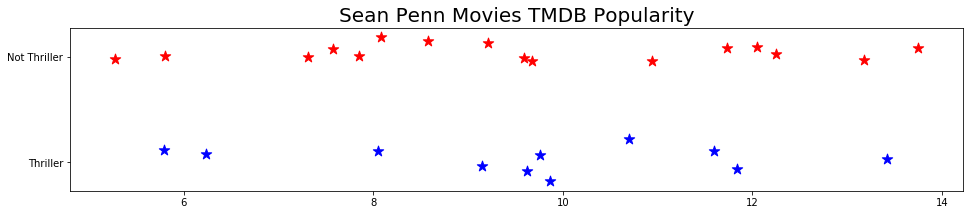

In [28]:
#Plot the distribution for popularity

fig, ax = plt.subplots(1, figsize=(16, 3))
ax.scatter(tested_for_genre_df['popularity'], np.repeat(0, len(tested_for_genre_df['popularity'])) + np.random.normal(0, 0.1, len(tested_for_genre_df['popularity'])), marker="*", c='blue', s=120)
ax.scatter(not_tested_for_genre_df['popularity'], np.repeat(1, len(not_tested_for_genre_df['popularity'])) + np.random.normal(0, 0.1, len(not_tested_for_genre_df['popularity'])),marker="*", c='red', s=120)
plt.title(actor + ' Movies TMDB Popularity', size = 20)
ax.set_yticks([0, 1])

ax.set_yticklabels([test_for_genre, "Not " + test_for_genre])  #generalize the label for and genre
#plt.tight_layout()

Null Hypothesis: H0 - There is no difference in the popularity of Hoffman's movies in drama vs. non-dramatic categories.
This hypothesis will be tested with the Rank Sum Statistic aka the U-Test

In [29]:
def count_winning_pairs(sample_1, sample_2):
    sample_1, sample_2 = np.array(sample_1), np.array(sample_2)
    n_total_wins = 0
    for x in sample_1:
        n_wins = np.sum(x > sample_2) + 0.5*np.sum(x == sample_2)
        n_total_wins += n_wins
    return n_total_wins

not_genre_wins = count_winning_pairs(not_tested_for_genre_df['popularity'], tested_for_genre_df['popularity'])
genre_wins = count_winning_pairs(tested_for_genre_df['popularity'], not_tested_for_genre_df['popularity'])
print("Total Number of Comparisons: {}\n".format(len(not_tested_for_genre_df['profit'])*len(tested_for_genre_df['profit'])))
print("Number of 'Not-in-Genre' Movie Wins: {}\n".format(not_genre_wins))
print("Number of In Genre: " + test_for_genre + " Movie Wins: {}".format(genre_wins))

Total Number of Comparisons: 176

Number of 'Not-in-Genre' Movie Wins: 84.0

Number of In Genre: Thriller Movie Wins: 92.0


The total number of wins is the total number of comparisons between a popularity of an "in genre" movie and the popularity of a not-in-genre movie.

In [30]:
# Now, using the U-Test (aka the Mann-Whitney U Statistic) calculate 
#    the Rank Sum Statistic
res = stats.mannwhitneyu(not_tested_for_genre_df['popularity'], tested_for_genre_df['popularity'], alternative="greater")
print("p-value for 'Not-in-Genre' Movie Popularity > " + test_for_genre + " Movie Popularity: {:2.3f}".format(res.pvalue))

p-value for 'Not-in-Genre' Movie Popularity > Thriller Movie Popularity: 0.588


*********************************

Here, we cannot reject the null hypothesis that Sean Penn's Thriller movies are more or less popularthan his thriller movies, at least in the measure of popularity in the TMDB.

*****Note that this conclusion will change for each actor and each genre tested!!!!

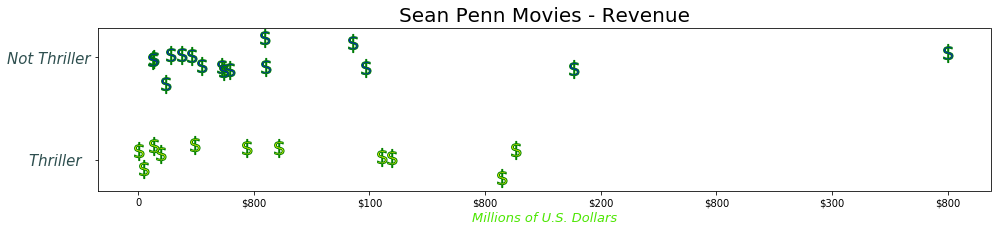

In [31]:
#Plot the distribution for profit
fig, ax = plt.subplots(1, figsize=(16, 3))
ax.scatter(tested_for_genre_df['revenue'], np.repeat(0, len(tested_for_genre_df['revenue'])) + np.random.normal(0, 0.1, len(tested_for_genre_df['revenue'])), marker='$''\$''$', c='yellow', edgecolors='green', s=330)
ax.scatter(not_tested_for_genre_df['revenue'], np.repeat(1, len(not_tested_for_genre_df['revenue'])) + np.random.normal(0, 0.1, len(not_tested_for_genre_df['revenue'])),marker='$''\$''$',c='blue', edgecolors='green', s=330)
plt.title(actor + ' Movies - Revenue', size=20)


def format_func(value, tick_number):
    # find number of multiples of pi/2
    N = int(np.round(value / 1000000))
    if N == 0:
        return "0"
    elif N == 100:
        return ("$100")
    elif N == 200:
        return ("$200")
    elif N == 300:
        return ("$300")
    elif N == 400:
        return ("$400")
    elif N == 500:
        return ("$500")
    elif N == 600:
        return ("$600")
    elif N == 700:
        return ("$700")
    else:
        return ("$800")

ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
ax.set_xlabel('Millions of U.S. Dollars', backgroundcolor='white', color=(.3, .9, .01), animated=True, fontstyle='italic', size=13)
ax.set_yticks([0, 1])
_nothing = ax.set_yticklabels([test_for_genre + "  ", "Not " + test_for_genre], fontstyle='oblique', color=(.18, .31, .31), size='15')
#plt.tight_layout()

******
Null Hypothesis: H0 - There is no difference in the revenue of Sean Penn's thriller movies in those movies not considerd thriller.
This hypothesis will be tested with the Rank Sum Statistic aka the U-Test
*******Note that this will change for each actor and genre tested.

In [32]:
def count_winning_pairs(sample_1, sample_2):
    sample_1, sample_2 = np.array(sample_1), np.array(sample_2)
    n_total_wins = 0
    for x in sample_1:
        n_wins = np.sum(x > sample_2) + 0.5*np.sum(x == sample_2)
        n_total_wins += n_wins
    return n_total_wins

not_genre_wins = count_winning_pairs(not_tested_for_genre_df['revenue'], tested_for_genre_df['revenue'])
genre_wins = count_winning_pairs(tested_for_genre_df['revenue'], not_tested_for_genre_df['revenue'])
print("Total Number of Comparisons: {}\n".format(len(not_tested_for_genre_df['revenue'])*len(tested_for_genre_df['revenue'])))
print("Number of 'Not-in-Genre' Movie Wins: {}\n".format(not_genre_wins))
print("Number of In Genre: " + test_for_genre + " Movie Wins: {}".format(genre_wins))

Total Number of Comparisons: 176

Number of 'Not-in-Genre' Movie Wins: 88.0

Number of In Genre: Thriller Movie Wins: 88.0


Remember, the total number of "wins" is the total number of comparisons between the revenue of a in-genre movie and the revenue of a not-in-genre movie.

In [33]:
# Now, using the U-Test (aka the Mann-Whitney U Statistic) calculate 
#    the Rank Sum Statistic
res = stats.mannwhitneyu(not_tested_for_genre_df['revenue'], tested_for_genre_df['revenue'], alternative="greater")

print("p-value for 'Not-in-Genre' Movie Popularity > " + test_for_genre + " Movie Popularity: {:2.3f}".format(res.pvalue))

p-value for 'Not-in-Genre' Movie Popularity > Thriller Movie Popularity: 0.510


******
Once again, we cannot reject the null hypothesis that there is no defference in revenue between Sean Penn's thriller and non-thriller movies.
*****Note that this conclusion willchange for each actor & genre tested.